In [2]:
import tensorflow as tf

# Display available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPUs available")

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)



No GPUs available
TensorFlow version: 2.10.1


In [3]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

Below Commented code is for changing directories for the image generator

In [4]:
# import os
# import shutil

# # Define the source directory where your images and masks are located
# source_directory = 'C:/Users/chenhuizingalab/Desktop/colon_segmentation/train'

# # Define the destination directories for images and masks
# image_destination_directory = os.path.join(source_directory, 'image')
# mask_destination_directory = os.path.join(source_directory, 'masks')

# # Create the destination directories if they don't exist
# os.makedirs(image_destination_directory, exist_ok=True)
# os.makedirs(mask_destination_directory, exist_ok=True)

# # List all files in the source directory
# files = os.listdir(source_directory)

# # Iterate through the files and move them to the appropriate destination
# for file in files:
#     if file.endswith('.jpg'):
#         # Check if a corresponding mask file exists
#         mask_file = file.replace('.jpg', '_mask.png')
#         if mask_file in files:
#             # Move both the image and mask files
#             shutil.move(os.path.join(source_directory, file), os.path.join(image_destination_directory, file))
#             shutil.move(os.path.join(source_directory, mask_file), os.path.join(mask_destination_directory, mask_file))

# print("Images and masks have been separated into 'image' and 'masks' directories while keeping them aligned.")

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers
import glob
import random
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from focal_loss import BinaryFocalLoss
from keras import backend as K
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers


seed=69
batch_size= 16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                          fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) 

In [6]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(".../Data/train_images", 
                                                           seed=seed,
                                                           target_size=(256, 256),
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(".../Data/train_masks", 
                                                         seed=seed,
                                                         target_size=(256, 256),
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)

Found 9816 images belonging to 1 classes.
Found 9816 images belonging to 1 classes.


In [7]:
valid_img_generator = image_data_generator.flow_from_directory(".../Data/valid_images", 
                                                               seed=seed,
                                                               target_size=(256, 256),
                                                               batch_size=batch_size, 
                                                               class_mode=None)
valid_mask_generator = mask_data_generator.flow_from_directory(".../Data/valid_masks", 
                                                               seed=seed,
                                                               target_size=(256,256),
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)

Found 906 images belonging to 1 classes.
Found 906 images belonging to 1 classes.


In [8]:
test_img_generator = image_data_generator.flow_from_directory(".../Data/test_images", 
                                                               seed=seed,
                                                               target_size=(256, 256),
                                                               batch_size=batch_size, 
                                                               class_mode=None) 
test_mask_generator = mask_data_generator.flow_from_directory(".../Data/test_masks", 
                                                               seed=seed,
                                                               target_size=(256,256),
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


In [9]:
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)


In [10]:
train_generator

In [11]:
X = image_generator.next()
y = mask_generator.next()

In [12]:
X_val = valid_img_generator.next()
y_val = valid_mask_generator.next()

In [13]:
X_test = test_img_generator.next()
y_test = test_mask_generator.next()

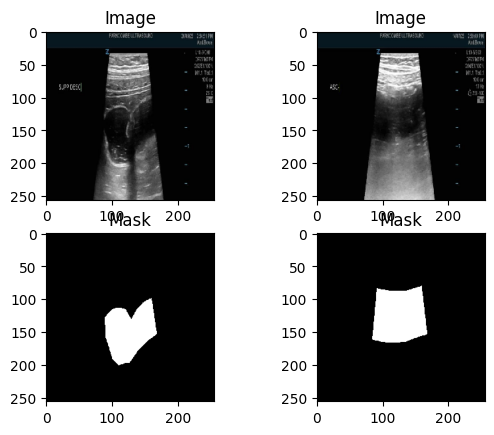

In [15]:
import random

num_samples_to_display = 2

# Assuming X and y are your image and mask data
# Get a list of random indices without replacement
indices = random.sample(range(len(X)), num_samples_to_display)

for i in range(num_samples_to_display):
    # Display the image
    plt.subplot(2, num_samples_to_display, i + 1)
    plt.imshow(X[indices[i]])
    plt.title("Image")

    # Display the mask
    plt.subplot(2, num_samples_to_display, num_samples_to_display + i + 1)
    plt.imshow(y[indices[i]], cmap='gray')  # Reshape if necessary
    plt.title("Mask")

plt.show()


In [16]:
#Parameters for model

IMG_HEIGHT = X.shape[1]
IMG_WIDTH  = X.shape[2]
IMG_CHANNELS = X.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [17]:
input_shape

(256, 256, 3)

In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottom
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2), metrics=['accuracy', jacard_coef])
    model.summary()

    return model



In [14]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS)

simple_unet_model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

C:\Users\chenhuizingalab\anaconda3\envs\py310_tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
num_train_imgs = len(os.listdir('.../Data/train_images/train/'))

steps_per_epoch = num_train_imgs // batch_size

In [16]:
steps_per_epoch

613

In [18]:
import time
from keras.callbacks import ModelCheckpoint

# Record start time
start_time = time.time()

# Define callbacks
best_model_checkpoint = ModelCheckpoint('.../colon_10kimages_model_best.hdf5',
                                        monitor='val_loss',
                                        save_best_only=True,
                                        mode='min',
                                        verbose=1)

last_model_checkpoint = ModelCheckpoint('.../colon_10kimages_model_last.hdf5',
                                        save_best_only=False,
                                        verbose=1)

# Train the model with callbacks
history = simple_unet_model.fit(train_generator, validation_data=val_generator,
                                steps_per_epoch=steps_per_epoch,
                                validation_steps=steps_per_epoch, 
                                epochs=30,
                                callbacks=[best_model_checkpoint, last_model_checkpoint])

# Record end time
end_time = time.time()

# Calculate total training time
training_time = end_time - start_time

# Calculate total training time in hours
training_time_hours = training_time / 3600

# Print the total training time in hours
print(f"Total training time: {training_time_hours:.2f} hours")



Epoch 1/30
613/613 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.8970 - jacard_coef: 7.5022e-04
Epoch 1: val_loss improved from inf to 0.01446, saving model to C:/Users/chenhuizingalab/Desktop/COLON_SEGMENTATION_2\colon_10kimages_model_best_try_3.hdf5

Epoch 1: saving model to C:/Users/chenhuizingalab/Desktop/COLON_SEGMENTATION_2\colon_10kimages_model_last_try_3.hdf5
613/613 [==============================] - 302s 469ms/step - loss: 0.0694 - accuracy: 0.8970 - jacard_coef: 7.5022e-04 - val_loss: 0.0145 - val_accuracy: 0.8879 - val_jacard_coef: 0.0024
Epoch 2/30
613/613 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.8896 - jacard_coef: 0.0025
Epoch 2: val_loss improved from 0.01446 to 0.00884, saving model to C:/Users/chenhuizingalab/Desktop/COLON_SEGMENTATION_2\colon_10kimages_model_best_try_3.hdf5

Epoch 2: saving model to C:/Users/chenhuizingalab/Desktop/COLON_SEGMENTATION_2\colon_10kimages_model_last_try_3.hdf5
613/613 [============

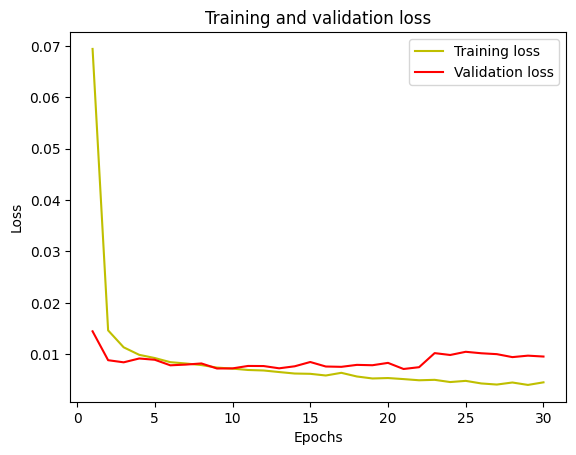

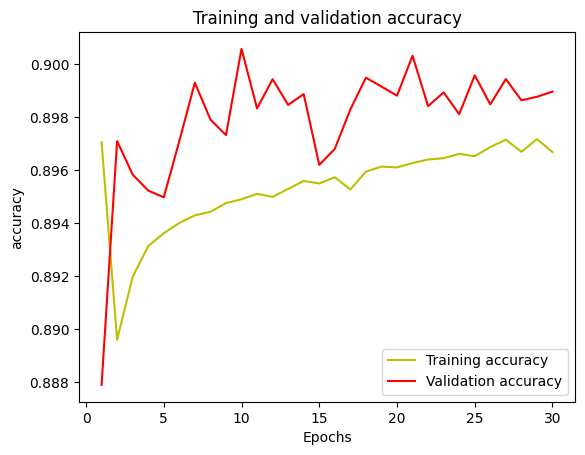

In [19]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show() 

In [18]:
new_model = load_model('.../colon_10kimages_model_best.hdf5', compile= False)

Train IOU

In [33]:
#IOU
y_pred=new_model.predict(X)
y_pred_thresholded = y_pred > 0.5
y_pred_thresholded = (y_pred_thresholded).astype(int)

intersection = np.logical_and(y, y_pred_thresholded)
union = np.logical_or(y, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)



1/1 [==============================] - 12s 12s/step
IoU score is:  0.9404912407440853


Test IOU

In [34]:
# Assuming new_model is your trained model, and X_test and y_test are your test data and labels
y_test_pred = new_model.predict(X_test)
y_test_pred_thresholded = y_test_pred > 0.5
y_test_pred_thresholded = y_test_pred_thresholded.astype(int)

intersection_test = np.logical_and(y_test, y_test_pred_thresholded)
union_test = np.logical_or(y_test, y_test_pred_thresholded)
iou_score_test = np.sum(intersection_test) / np.sum(union_test)
print("IoU score for the test set is: ", iou_score_test)

1/1 [==============================] - 0s 45ms/step
IoU score for the test set is:  0.9026905328647171


Validation IOU

In [17]:
# Calculate IoU for the entire validation set
y_val_pred = new_model.predict(X_val)
y_val_pred_thresholded = y_val_pred > 0.5
y_val_pred_thresholded = y_val_pred_thresholded.astype(int)

intersection_val = np.logical_and(y_val, y_val_pred_thresholded)
union_val = np.logical_or(y_val, y_val_pred_thresholded)
iou_score_val = np.sum(intersection_val) / np.sum(union_val)
print("IoU score for the validation set is: ", iou_score_val)

1/1 [==============================] - 0s 183ms/step
IoU score for the validation set is:  0.8480241472538054


# images of train set 

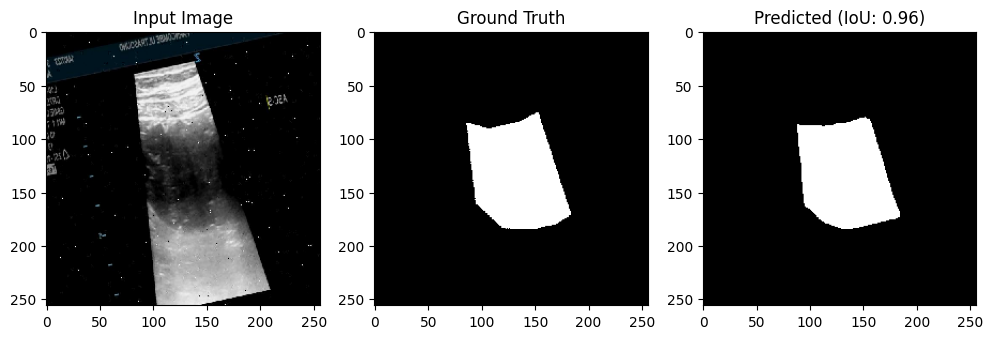

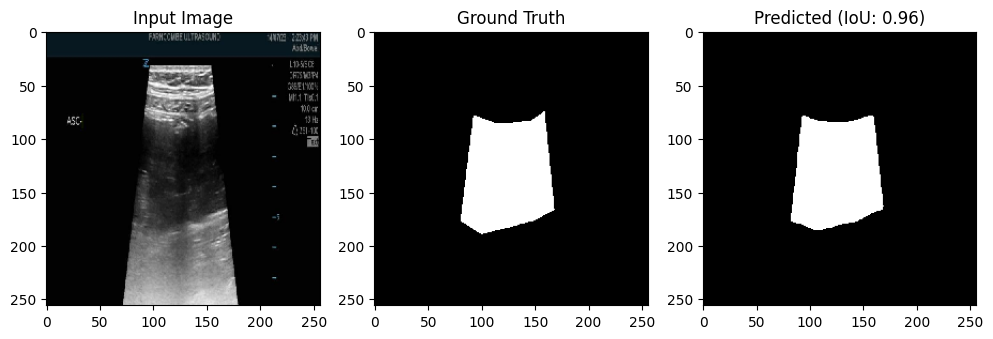

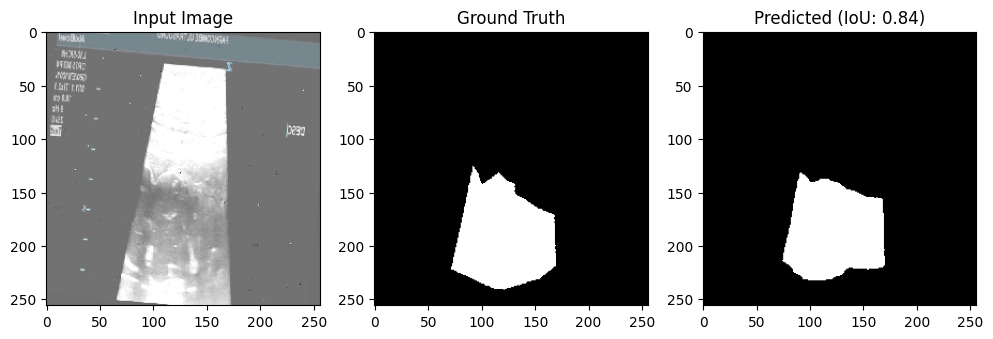

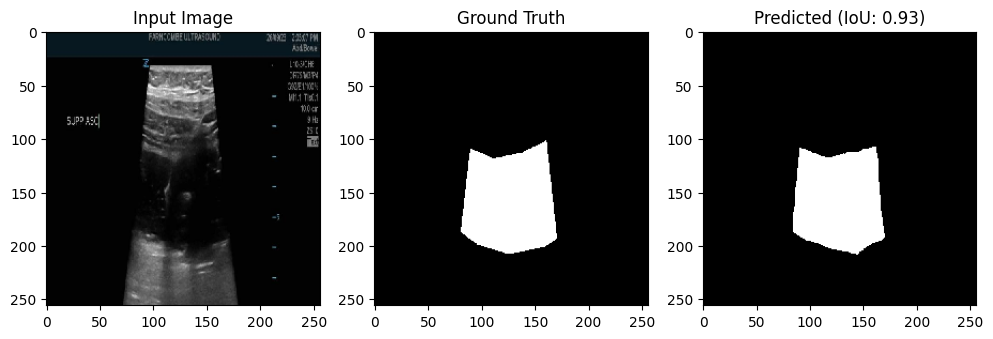

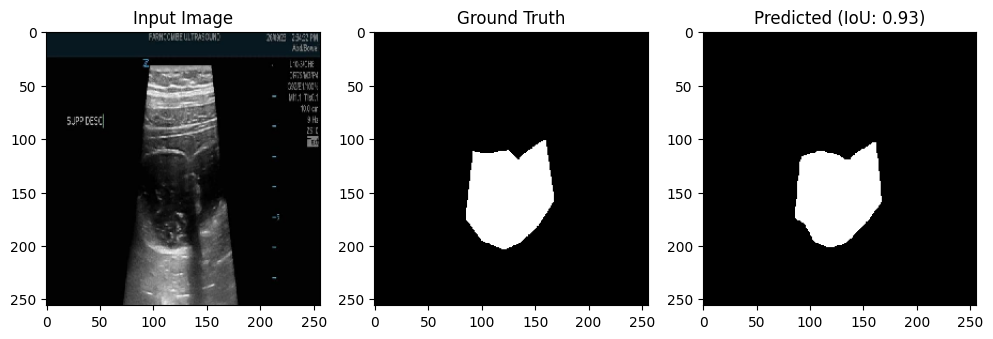

In [30]:
# Iterate through some random images
num_images_to_display = 5  # Adjust this as needed
random_indices = np.random.choice(len(X), num_images_to_display, replace=False)

for i in random_indices:
    # Calculate IoU for each image
    y_pred_thresholded = y_pred[i] > 0.5
    y_pred_thresholded = y_pred_thresholded.astype(int)

    intersection = np.logical_and(y[i], y_pred_thresholded)
    union = np.logical_or(y[i], y_pred_thresholded)
    iou_score = np.sum(intersection) / np.sum(union)

    # Display the images, ground truth, and predicted labels
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X[i])
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(y[i], cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_thresholded, cmap='gray')
    plt.title(f'Predicted (IoU: {iou_score:.2f})')

    plt.show()



# images on val set

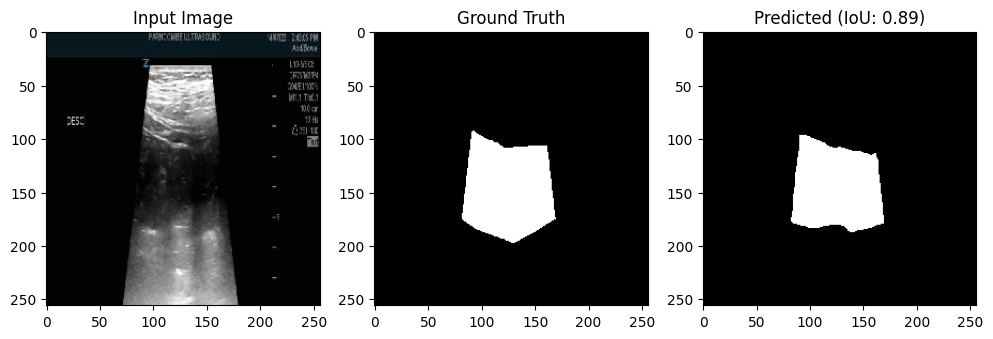

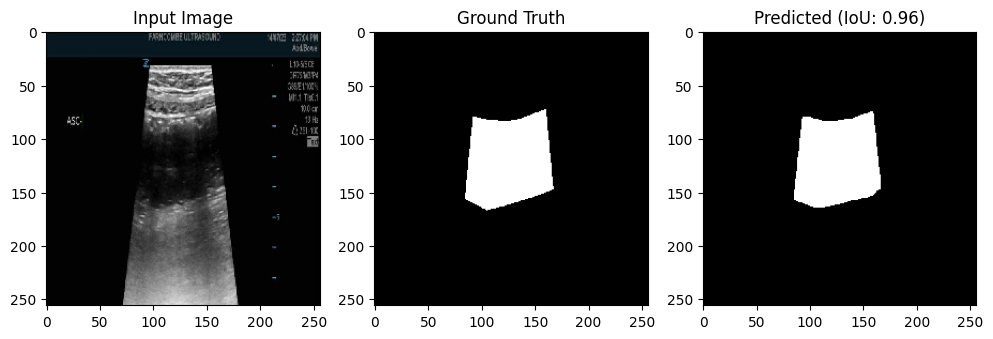

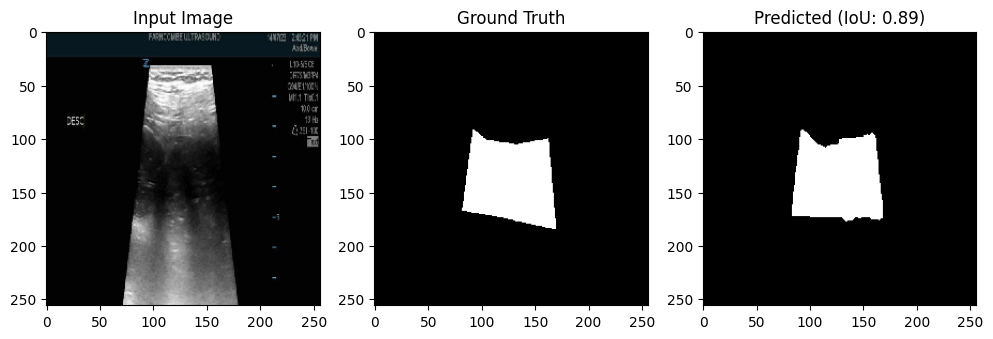

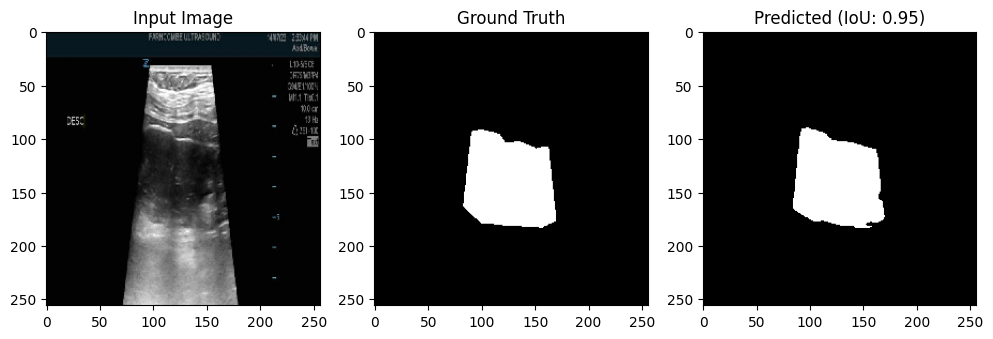

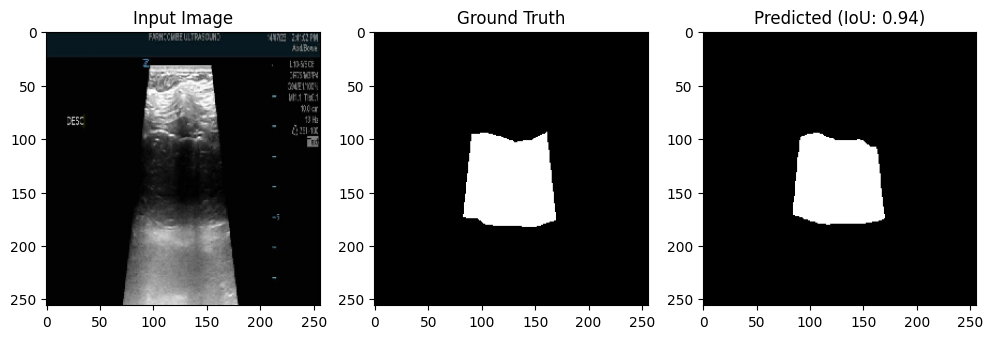

In [19]:
# Iterate through some random images in the validation set
num_images_to_display = 5  # Adjust this as needed
random_indices_val = np.random.choice(len(X_val), num_images_to_display, replace=False)

for i in random_indices_val:
    # Calculate IoU for each image in the validation set
    y_val_pred_thresholded_single = y_val_pred[i] > 0.5
    y_val_pred_thresholded_single = y_val_pred_thresholded_single.astype(int)

    intersection_single = np.logical_and(y_val[i], y_val_pred_thresholded_single)
    union_single = np.logical_or(y_val[i], y_val_pred_thresholded_single)
    iou_score_single = np.sum(intersection_single) / np.sum(union_single)

    # Display the images, ground truth, and predicted labels
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i], cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(y_val_pred_thresholded_single, cmap='gray')
    plt.title(f'Predicted (IoU: {iou_score_single:.2f})')

    plt.show()

# images on test set 


1/1 [==============================] - 0s 44ms/step


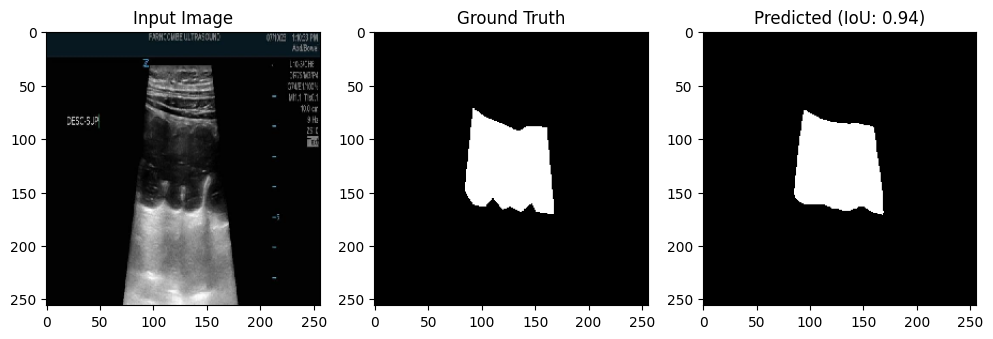

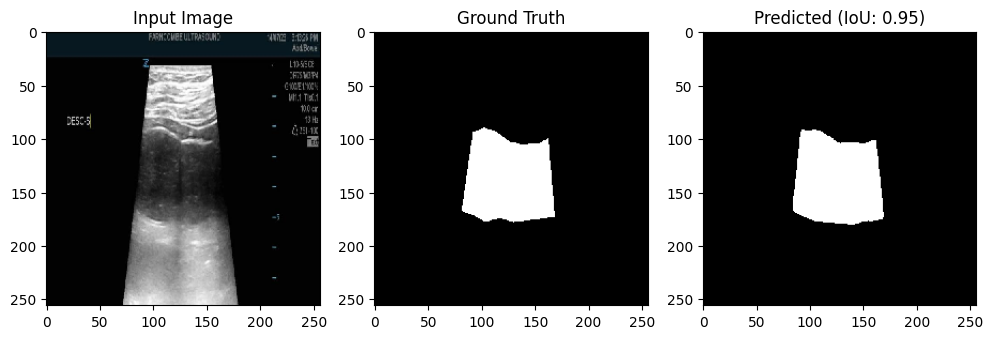

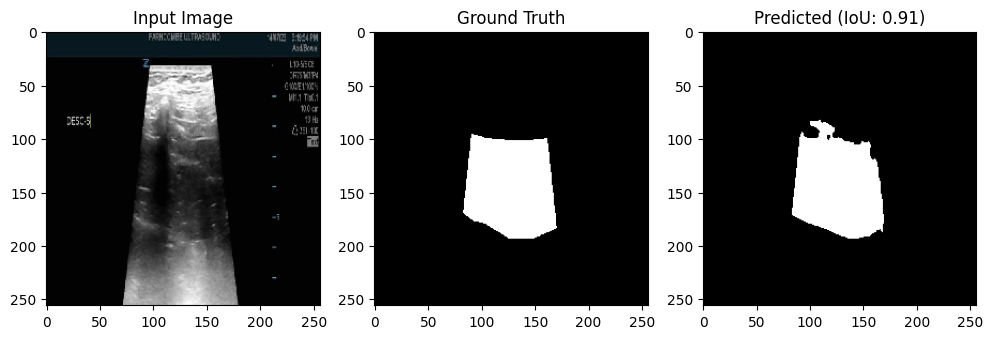

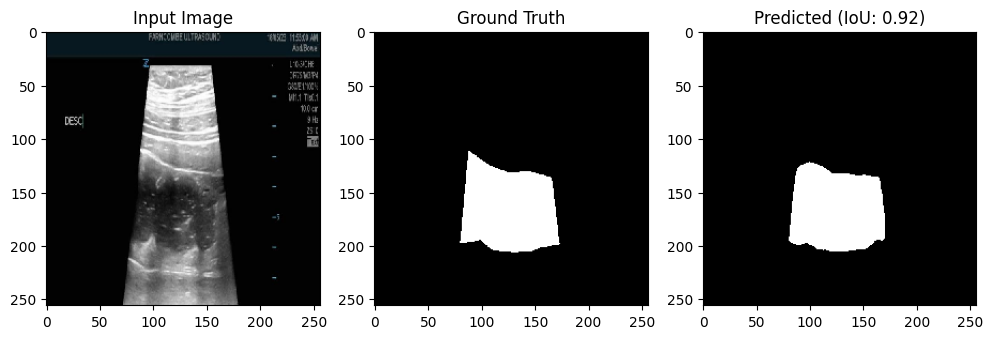

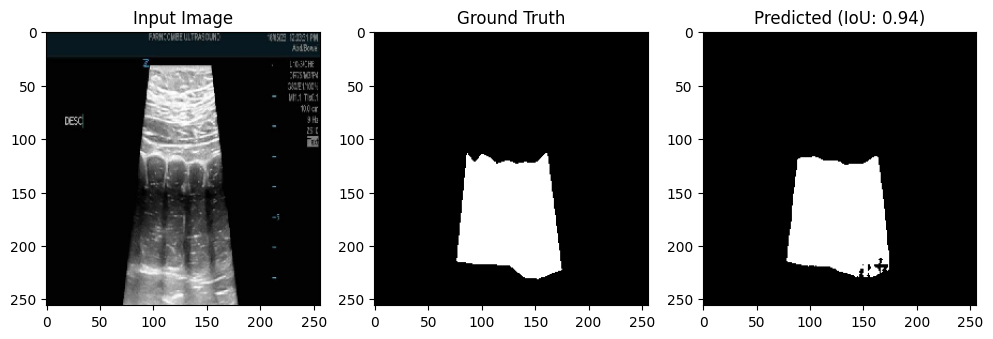

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Number of images to display
num_images_to_display = 5  # Adjust this as needed

# Randomly select indices for images to display
random_indices_test = np.random.choice(len(X_test), num_images_to_display, replace=False)

# Predict masks for the test set
y_test_pred = new_model.predict(X_test)
y_test_pred_thresholded = y_test_pred > 0.5
y_test_pred_thresholded = y_test_pred_thresholded.astype(int)

# Iterate through the randomly selected images
for i in random_indices_test:
    # Calculate IoU for each image in the test set
    y_test_pred_thresholded_single = y_test_pred_thresholded[i]
    y_test_true_single = y_test[i]

    intersection_single = np.logical_and(y_test_true_single, y_test_pred_thresholded_single)
    union_single = np.logical_or(y_test_true_single, y_test_pred_thresholded_single)
    iou_score_single = np.sum(intersection_single) / np.sum(union_single)

    # Display the images, ground truth, and predicted labels
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(y_test_true_single, cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(y_test_pred_thresholded_single, cmap='gray')
    plt.title(f'Predicted (IoU: {iou_score_single:.2f})')

    plt.show()
